<a href="https://colab.research.google.com/github/BoopeshMohanraj/Cross-Chain-Money-Fraud-Laundering-ML-Detection-System-across-Blockchain/blob/main/Cross-Chain-Money-Fraud-Laundering-ML-Detection-System-across-Blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn sqlalchemy plotly networkx requests web3 joblib

# Confirm installations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sqlalchemy
import sqlite3
import requests
import json
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

print("Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.5/587.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.7/313.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.7 MB/s eta 0:00:00
Setup complete!


In [2]:
# Create a SQLite database connection
conn = sqlite3.connect('crypto_fraud.db')
cursor = conn.cursor()

# Create tables to store our blockchain data
cursor.execute('''
CREATE TABLE IF NOT EXISTS addresses (
    id INTEGER PRIMARY KEY,
    address TEXT NOT NULL,
    chain TEXT NOT NULL,
    first_seen TIMESTAMP,
    last_seen TIMESTAMP,
    total_sent REAL,
    total_received REAL,
    entity_type TEXT,
    risk_score REAL,
    is_sanctioned INTEGER,
    UNIQUE(address, chain)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS transactions (
    id INTEGER PRIMARY KEY,
    txid TEXT NOT NULL,
    chain TEXT NOT NULL,
    block_number INTEGER,
    timestamp TIMESTAMP,
    fee REAL,
    value REAL,
    from_address TEXT,
    to_address TEXT,
    UNIQUE(txid, chain)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS bridge_transactions (
    id INTEGER PRIMARY KEY,
    source_txid TEXT,
    source_chain TEXT,
    destination_txid TEXT,
    destination_chain TEXT,
    bridge_name TEXT,
    source_address TEXT,
    destination_address TEXT,
    source_value REAL,
    destination_value REAL,
    timestamp TIMESTAMP,
    time_to_complete INTEGER
)
''')

conn.commit()
print("Database setup complete!")

Database setup complete!


In [3]:
# Function to fetch Ethereum transactions using Etherscan API
def fetch_ethereum_transactions(api_key, address, start_block=0, end_block=99999999):
    base_url = "https://api.etherscan.io/api"
    params = {
        "module": "account",
        "action": "txlist",
        "address": address,
        "startblock": start_block,
        "endblock": end_block,
        "sort": "asc",
        "apikey": api_key
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if data["status"] == "1":
        return data["result"]
    else:
        print(f"Error fetching Ethereum transactions: {data['message']}")
        return []

# Function to fetch Bitcoin transactions using BlockCypher API
def fetch_bitcoin_transactions(address):
    base_url = f"https://api.blockcypher.com/v1/btc/main/addrs/{address}/full"
    params = {"limit": 50}

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching Bitcoin transactions: {response.status_code}")
        return {}

# Get your API key from Etherscan
ETHERSCAN_API_KEY = "YOUR_ETHERSCAN_API_KEY"  # Replace with your actual API key

# Example addresses known to be involved in bridge transactions
eth_addresses = [
    "0x8589427373D6D84E98730D7795D8f6f8731FDA16",  # Tornado Cash (now sanctioned)
    "0x3f5CE5FBFe3E9af3971dD833D26bA9b5C936f0bE",  # Binance Hot Wallet
    "0x40ec5B33f54e0E8A33A975908C5BA1c14e5BbbDf"   # Polygon Bridge
]

btc_addresses = [
    "bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh",  # High volume address
    "3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64",         # Bridge-related address
]

# Collect and store Ethereum transactions
for address in eth_addresses:
    print(f"Fetching Ethereum transactions for {address}...")
    eth_txs = fetch_ethereum_transactions(ETHERSCAN_API_KEY, address)

    if eth_txs:
        # Add address to addresses table
        cursor.execute('''
        INSERT OR IGNORE INTO addresses (address, chain, first_seen, last_seen)
        VALUES (?, ?, ?, ?)
        ''', (address, 'ethereum',
              datetime.fromtimestamp(int(eth_txs[0]['timeStamp'])),
              datetime.fromtimestamp(int(eth_txs[-1]['timeStamp']))))

        # Add transactions to transactions table
        for tx in eth_txs:
            cursor.execute('''
            INSERT OR IGNORE INTO transactions
            (txid, chain, block_number, timestamp, fee, value, from_address, to_address)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                tx['hash'],
                'ethereum',
                int(tx['blockNumber']),
                datetime.fromtimestamp(int(tx['timeStamp'])),
                float(tx['gasPrice']) * float(tx['gasUsed']) / 1e18,  # Convert to ETH
                float(tx['value']) / 1e18,  # Convert to ETH
                tx['from'],
                tx['to']
            ))

        conn.commit()
        print(f"Added {len(eth_txs)} Ethereum transactions for {address}")

# Collect and store Bitcoin transactions
for address in btc_addresses:
    print(f"Fetching Bitcoin transactions for {address}...")
    btc_data = fetch_bitcoin_transactions(address)

    if 'txs' in btc_data:
        btc_txs = btc_data['txs']

        # Add address to addresses table
        first_seen = btc_txs[0]['confirmed'] if 'confirmed' in btc_txs[0] else datetime.now().isoformat()
        last_seen = btc_txs[-1]['confirmed'] if 'confirmed' in btc_txs[-1] else datetime.now().isoformat()

        cursor.execute('''
        INSERT OR IGNORE INTO addresses (address, chain, first_seen, last_seen)
        VALUES (?, ?, ?, ?)
        ''', (address, 'bitcoin', first_seen, last_seen))

        # Add transactions to transactions table
        for tx in btc_txs:
            # For Bitcoin we need to handle inputs and outputs
            for inp in tx.get('inputs', []):
                if 'prev_hash' in inp and 'addresses' in inp and inp['addresses'] and inp['addresses'][0] == address:
                    for out in tx.get('outputs', []):
                        if 'addresses' in out and out['addresses']:
                            cursor.execute('''
                            INSERT OR IGNORE INTO transactions
                            (txid, chain, block_number, timestamp, fee, value, from_address, to_address)
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                            ''', (
                                tx['hash'],
                                'bitcoin',
                                tx.get('block_height', 0),
                                tx.get('confirmed', datetime.now().isoformat()),
                                float(tx.get('fees', 0)) / 1e8,  # Convert to BTC
                                float(out.get('value', 0)) / 1e8,  # Convert to BTC
                                address,
                                out['addresses'][0]
                            ))

        conn.commit()
        print(f"Added Bitcoin transactions for {address}")

print("Data collection complete!")

Fetching Ethereum transactions for 0x8589427373D6D84E98730D7795D8f6f8731FDA16...
Error fetching Ethereum transactions: NOTOK
Fetching Ethereum transactions for 0x3f5CE5FBFe3E9af3971dD833D26bA9b5C936f0bE...
Error fetching Ethereum transactions: NOTOK
Fetching Ethereum transactions for 0x40ec5B33f54e0E8A33A975908C5BA1c14e5BbbDf...
Error fetching Ethereum transactions: NOTOK
Fetching Bitcoin transactions for bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh...
Added Bitcoin transactions for bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh
Fetching Bitcoin transactions for 3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64...
Added Bitcoin transactions for 3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64
Data collection complete!


In [4]:
# Create a function to execute SQL queries and return results as pandas DataFrame
def execute_query(query):
    return pd.read_sql_query(query, conn)

# SQL query to find high-value transactions that might be bridge-related
bridge_candidates_query = """
SELECT
    t.txid,
    t.chain,
    t.from_address,
    t.to_address,
    t.value,
    t.timestamp,
    a1.risk_score as from_risk_score,
    a2.risk_score as to_risk_score
FROM transactions t
LEFT JOIN addresses a1 ON t.from_address = a1.address AND t.chain = a1.chain
LEFT JOIN addresses a2 ON t.to_address = a2.address AND t.chain = a2.chain
WHERE t.value > 1.0  -- High value transactions
ORDER BY t.value DESC
LIMIT 100;
"""

# Execute the query
bridge_candidates = execute_query(bridge_candidates_query)
print(f"Found {len(bridge_candidates)} potential high-value transactions")
bridge_candidates.head()

# SQL query to find addresses with transactions on multiple chains (possible bridge users)
multi_chain_addresses_query = """
WITH address_chains AS (
    -- Addresses as senders
    SELECT from_address as address, chain, COUNT(*) as tx_count
    FROM transactions
    GROUP BY from_address, chain

    UNION ALL

    -- Addresses as receivers
    SELECT to_address as address, chain, COUNT(*) as tx_count
    FROM transactions
    GROUP BY to_address, chain
)

SELECT
    address,
    COUNT(DISTINCT chain) as chain_count,
    SUM(tx_count) as total_transactions
FROM address_chains
GROUP BY address
HAVING COUNT(DISTINCT chain) > 1
ORDER BY chain_count DESC, total_transactions DESC;
"""

# Execute the query
multi_chain_addresses = execute_query(multi_chain_addresses_query)
print(f"Found {len(multi_chain_addresses)} addresses active on multiple chains")
multi_chain_addresses.head()

Found 3 potential high-value transactions
Found 0 addresses active on multiple chains


,address,chain_count,total_transactions


In [5]:
# Generate synthetic data for training our model
def generate_synthetic_data(n_samples=1000):
    # Create random timestamps within the last 6 months
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days

    # Parameters for legitimate vs. fraudulent patterns
    np.random.seed(42)

    # Create DataFrame
    data = pd.DataFrame()

    # Basic transaction features
    data['transaction_count'] = np.random.poisson(10, n_samples)  # Number of transactions
    data['unique_chains'] = np.random.randint(1, 5, n_samples)    # Number of unique chains used
    data['max_value'] = np.random.exponential(5, n_samples)       # Max transaction value
    data['avg_value'] = data['max_value'] * np.random.uniform(0.2, 0.8, n_samples)

    # Time-based features
    data['avg_time_between_tx'] = np.random.exponential(24, n_samples)  # Hours
    data['min_time_between_tx'] = data['avg_time_between_tx'] * np.random.uniform(0.1, 0.9, n_samples)

    # Bridge specific features
    data['bridge_count'] = np.random.randint(0, 5, n_samples)        # Number of bridges used
    data['round_trips'] = np.random.randint(0, 3, n_samples)         # A->B->A patterns
    data['chain_hop_frequency'] = np.random.exponential(2, n_samples)  # Chain hops per day

    # Additional features
    data['unique_destinations'] = np.random.poisson(5, n_samples)     # Unique addresses sent to
    data['tx_per_chain'] = data['transaction_count'] / np.maximum(data['unique_chains'], 1)

    # Generate labels - this is simplified but represents patterns
    # More complex: Create a matrix of features that represent known laundering patterns

    # These patterns are based on research on laundering techniques
    is_laundering = (
        ((data['bridge_count'] > 2) & (data['min_time_between_tx'] < 1)) |  # Multiple bridges in short time
        ((data['round_trips'] > 0) & (data['unique_chains'] > 2)) |         # Round trips across multiple chains
        ((data['chain_hop_frequency'] > 5) & (data['unique_destinations'] < 3)) |  # Rapid chain hopping to few destinations
        ((data['max_value'] > 10) & (data['bridge_count'] > 1) & (data['avg_time_between_tx'] < 12))  # High value through bridges quickly
    )

    # Add some randomness - not all that look suspicious are fraudulent
    noise = np.random.choice([True, False], size=n_samples, p=[0.05, 0.95])
    data['is_laundering'] = (is_laundering ^ noise).astype(int)  # XOR with noise

    return data

# Generate synthetic data
synthetic_data = generate_synthetic_data(2000)
print(f"Generated {len(synthetic_data)} synthetic transactions")
print(f"Laundering cases: {synthetic_data['is_laundering'].sum()} ({synthetic_data['is_laundering'].mean()*100:.1f}%)")

# Store synthetic data in SQLite database
synthetic_data.to_sql('synthetic_features', conn, if_exists='replace', index=False)
print("Stored synthetic data in database")

# Retrieve synthetic data using SQL for verification
synthetic_data_sql = execute_query("""
SELECT * FROM synthetic_features
LIMIT 5;
""")
print("Retrieved synthetic data from database:")
synthetic_data_sql.head()

Generated 2000 synthetic transactions
Laundering cases: 819 (40.9%)
Stored synthetic data in database
Retrieved synthetic data from database:


,transaction_count,unique_chains,max_value,avg_value,avg_time_between_tx,min_time_between_tx,bridge_count,round_trips,chain_hop_frequency,unique_destinations,tx_per_chain,is_laundering
0,12,3,5.554345,1.208083,73.606171,28.042163,1,2,1.334099,8,4.000000,1
1,6,4,1.569716,0.883846,1.320756,0.463722,2,0,1.236004,5,1.500000,0
2,11,4,1.625347,0.711003,29.648813,19.193685,3,0,1.136232,6,2.750000,0
3,14,2,13.546239,5.136779,18.228587,4.966098,2,2,1.370269,3,7.000000,0
4,7,3,6.428348,4.629468,15.596454,6.795746,3,1,8.689166,5,2.333333,1


Fraud patterns by bridge count:
   bridge_count  avg_unique_chains  avg_min_time_hours  avg_hop_frequency  \
0             0           2.423529           12.459170           2.024529   
1             1           2.502538           12.156576           1.923416   
2             2           2.570681           12.547143           1.998315   
3             3           2.463659           12.171617           1.990851   
4             4           2.490000           12.071346           1.959109   

   avg_round_trips  fraud_count  total_count  fraud_rate  
0         1.058824          138          425    0.324706  
1         1.015228          147          394    0.373096  
2         0.973822          157          382    0.410995  
3         1.030075          178          399    0.446115  
4         1.072500          199          400    0.497500  

Fraud patterns by transaction speed:
          tx_speed  avg_bridges  avg_chains  fraud_count  total_count  \
0  Very Fast (<1h)     2.129032    2.585

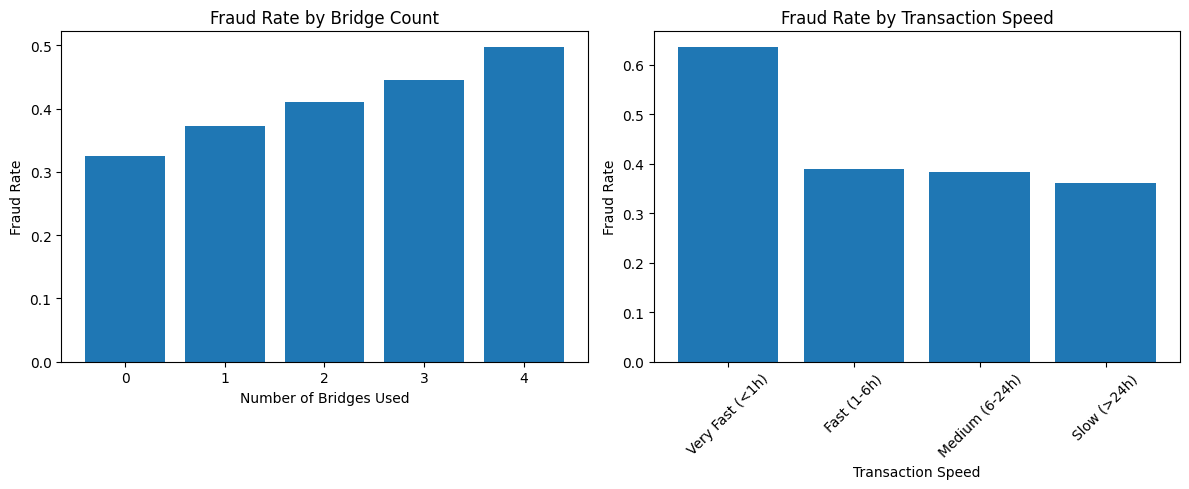

In [6]:
# SQL query for exploratory analysis
fraud_patterns_query = """
SELECT
    bridge_count,
    AVG(unique_chains) as avg_unique_chains,
    AVG(min_time_between_tx) as avg_min_time_hours,
    AVG(chain_hop_frequency) as avg_hop_frequency,
    AVG(round_trips) as avg_round_trips,
    SUM(is_laundering) as fraud_count,
    COUNT(*) as total_count,
    CAST(SUM(is_laundering) AS FLOAT) / COUNT(*) as fraud_rate
FROM synthetic_features
GROUP BY bridge_count
ORDER BY bridge_count;
"""

# Execute the query
fraud_patterns = execute_query(fraud_patterns_query)
print("Fraud patterns by bridge count:")
print(fraud_patterns)

# SQL query for time-based analysis
time_analysis_query = """
SELECT
    CASE
        WHEN min_time_between_tx < 1 THEN 'Very Fast (<1h)'
        WHEN min_time_between_tx < 6 THEN 'Fast (1-6h)'
        WHEN min_time_between_tx < 24 THEN 'Medium (6-24h)'
        ELSE 'Slow (>24h)'
    END as tx_speed,
    AVG(bridge_count) as avg_bridges,
    AVG(unique_chains) as avg_chains,
    SUM(is_laundering) as fraud_count,
    COUNT(*) as total_count,
    CAST(SUM(is_laundering) AS FLOAT) / COUNT(*) as fraud_rate
FROM synthetic_features
GROUP BY tx_speed
ORDER BY MIN(min_time_between_tx);
"""

# Execute the query
time_analysis = execute_query(time_analysis_query)
print("\nFraud patterns by transaction speed:")
print(time_analysis)

# Visualize results
plt.figure(figsize=(12, 5))

# Plot 1: Fraud rate by bridge count
plt.subplot(1, 2, 1)
plt.bar(fraud_patterns['bridge_count'], fraud_patterns['fraud_rate'])
plt.xlabel('Number of Bridges Used')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Bridge Count')

# Plot 2: Fraud rate by transaction speed
plt.subplot(1, 2, 2)
plt.bar(time_analysis['tx_speed'], time_analysis['fraud_rate'])
plt.xlabel('Transaction Speed')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Speed')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# SQL Query for Feature Selection and Preprocessing
features_query = """
SELECT
    transaction_count,
    unique_chains,
    max_value,
    avg_value,
    avg_time_between_tx,
    min_time_between_tx,
    bridge_count,
    round_trips,
    chain_hop_frequency,
    unique_destinations,
    tx_per_chain,
    is_laundering
FROM synthetic_features;
"""

# Execute the query
model_data = execute_query(features_query)

# Check class balance
print(f"Class distribution: {model_data['is_laundering'].value_counts()}")
print(f"Percentage of laundering cases: {model_data['is_laundering'].mean()*100:.2f}%")

# Split features and target
X = model_data.drop('is_laundering', axis=1)
y = model_data['is_laundering']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Class distribution: is_laundering
0    1181
1     819
Name: count, dtype: int64
Percentage of laundering cases: 40.95%
Training set: (1400, 11)
Testing set: (600, 11)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       354
           1       0.93      0.90      0.92       246

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



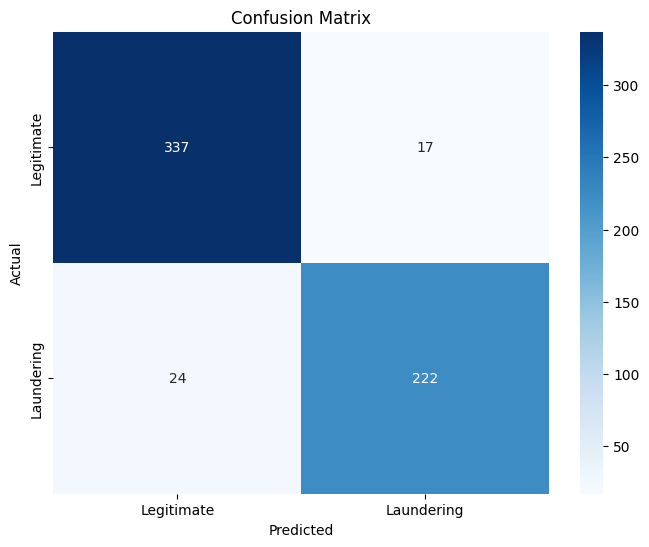

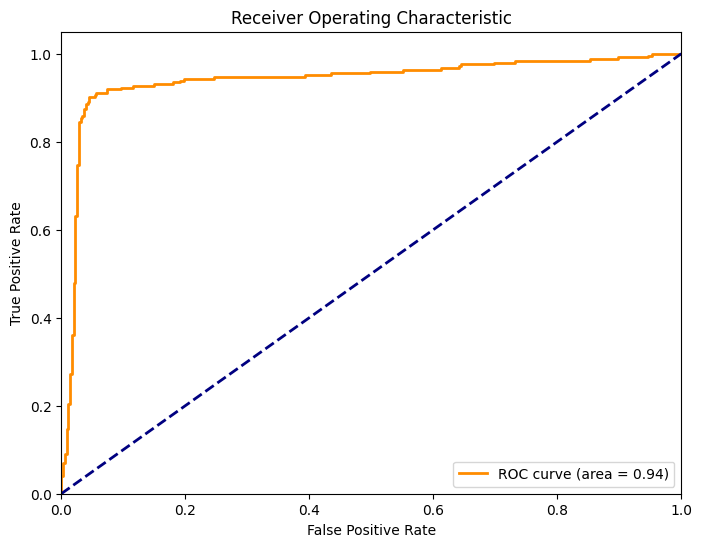

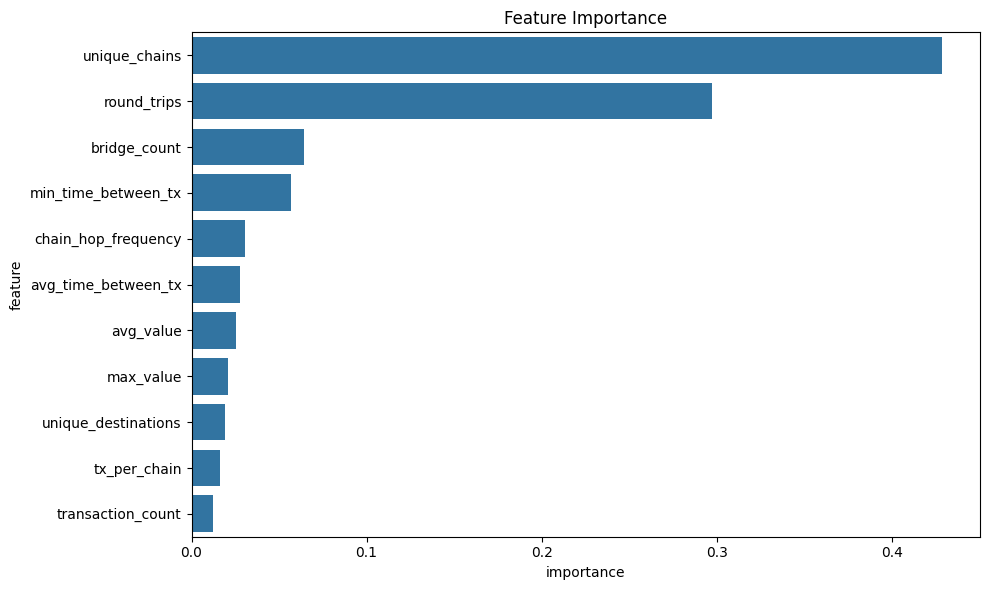

Model saved to disk


In [8]:
# Initialize the model
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Laundering'],
            yticklabels=['Legitimate', 'Laundering'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Save the model
import joblib
joblib.dump(model, 'cross_chain_fraud_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("Model saved to disk")

In [10]:
# Create a table to store model predictions
cursor.execute('''
CREATE TABLE IF NOT EXISTS model_predictions (
    id INTEGER PRIMARY KEY,
    transaction_count INTEGER,
    unique_chains INTEGER,
    bridge_count INTEGER,
    round_trips INTEGER,
    predicted_label INTEGER,
    probability REAL,
    actual_label INTEGER
)
''')
conn.commit()

# Store test set predictions
test_predictions = pd.DataFrame({
    'transaction_count': X_test['transaction_count'].values,
    'unique_chains': X_test['unique_chains'].values,
    'bridge_count': X_test['bridge_count'].values,
    'round_trips': X_test['round_trips'].values,
    'predicted_label': y_pred,
    'probability': y_prob,
    'actual_label': y_test.values
})

test_predictions.to_sql('model_predictions', conn, if_exists='replace', index=False)
print("Predictions stored in database")

# SQL query for the dashboard
dashboard_query = """
SELECT
    bridge_count,
    round_trips,
    COUNT(*) as total_count,
    SUM(predicted_label) as predicted_fraud_count,
    SUM(actual_label) as actual_fraud_count,
    AVG(probability) as avg_fraud_probability
FROM model_predictions
GROUP BY bridge_count, round_trips
ORDER BY bridge_count, round_trips;
"""

dashboard_data = execute_query(dashboard_query)
print("Dashboard data:")
print(dashboard_data.head())

# Create a visual dashboard using Plotly
fig = px.scatter(dashboard_data,
                x="bridge_count",
                y="round_trips",
                size="total_count",
                color="avg_fraud_probability",
                hover_data=["predicted_fraud_count", "actual_fraud_count"],
                color_continuous_scale=px.colors.sequential.Reds,
                title="Cross-Chain Laundering Risk Dashboard")

fig.update_layout(
    xaxis_title="Number of Bridges Used",
    yaxis_title="Number of Round-Trip Transactions",
    coloraxis_colorbar_title="Fraud Probability"
)

fig.show()

# Create a 3D visualization
fig2 = px.scatter_3d(
    test_predictions,
    x='unique_chains',
    y='bridge_count',
    z='transaction_count',
    color='probability',
    size='bridge_count',
    opacity=0.7,
    color_continuous_scale=px.colors.sequential.Plasma,
    title="3D Visualization of Cross-Chain Laundering Risk"
)

fig2.update_layout(
    scene=dict(
        xaxis_title="Unique Chains",
        yaxis_title="Bridge Count",
        zaxis_title="Transaction Count"
    )
)

fig2.show()

Predictions stored in database
Dashboard data:
   bridge_count  round_trips  total_count  predicted_fraud_count  \
0             0            0           30                      0   
1             0            1           58                     29   
2             0            2           44                     14   
3             1            0           36                      1   
4             1            1           44                     19   

   actual_fraud_count  avg_fraud_probability  
0                   2               0.073499  
1                  29               0.493030  
2                  14               0.334841  
3                   4               0.063308  
4                  19               0.433396  


In [11]:
def evaluate_transaction(transaction_features):
    """
    Evaluate a new transaction for fraud risk

    Parameters:
    transaction_features (dict): Dictionary with transaction features

    Returns:
    dict: Risk assessment results
    """
    # Ensure all required features are present
    required_features = [
        'transaction_count', 'unique_chains', 'max_value', 'avg_value',
        'avg_time_between_tx', 'min_time_between_tx', 'bridge_count',
        'round_trips', 'chain_hop_frequency', 'unique_destinations', 'tx_per_chain'
    ]

    # Create a feature vector
    feature_vector = []
    for feature in required_features:
        if feature not in transaction_features:
            print(f"Warning: Missing feature {feature}. Using default value.")
            transaction_features[feature] = 0
        feature_vector.append(transaction_features[feature])

    # Reshape for single sample
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Scale features
    scaled_features = scaler.transform(feature_vector)

    # Get prediction and probability
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0, 1]

    # Create result
    result = {
        'is_suspicious': bool(prediction),
        'risk_score': float(probability),
        'risk_level': 'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low',
        'features_analyzed': required_features,
        'timestamp': datetime.now().isoformat()
    }

    return result

# Example of using the real-time evaluation function
example_transaction = {
    'transaction_count': 15,
    'unique_chains': 3,
    'max_value': 12.5,
    'avg_value': 4.2,
    'avg_time_between_tx': 2.3,
    'min_time_between_tx': 0.5,
    'bridge_count': 2,
    'round_trips': 1,
    'chain_hop_frequency': 4.8,
    'unique_destinations': 3,
    'tx_per_chain': 5.0
}

risk_assessment = evaluate_transaction(example_transaction)
print("Transaction Risk Assessment:")
for key, value in risk_assessment.items():
    print(f"{key}: {value}")

# Store transaction and assessment in the database
cursor.execute('''
CREATE TABLE IF NOT EXISTS risk_assessments (
    id INTEGER PRIMARY KEY,
    timestamp TEXT,
    transaction_data TEXT,
    is_suspicious INTEGER,
    risk_score REAL,
    risk_level TEXT
)
''')

cursor.execute('''
INSERT INTO risk_assessments (timestamp, transaction_data, is_suspicious, risk_score, risk_level)
VALUES (?, ?, ?, ?, ?)
''', (
    risk_assessment['timestamp'],
    json.dumps(example_transaction),
    int(risk_assessment['is_suspicious']),
    risk_assessment['risk_score'],
    risk_assessment['risk_level']
))

conn.commit()
print("Risk assessment stored in database")

Transaction Risk Assessment:
is_suspicious: True
risk_score: 0.9903877941628054
risk_level: High
features_analyzed: ['transaction_count', 'unique_chains', 'max_value', 'avg_value', 'avg_time_between_tx', 'min_time_between_tx', 'bridge_count', 'round_trips', 'chain_hop_frequency', 'unique_destinations', 'tx_per_chain']
timestamp: 2025-05-19T13:09:12.546436
Risk assessment stored in database


Created network with 65 nodes and 57 edges


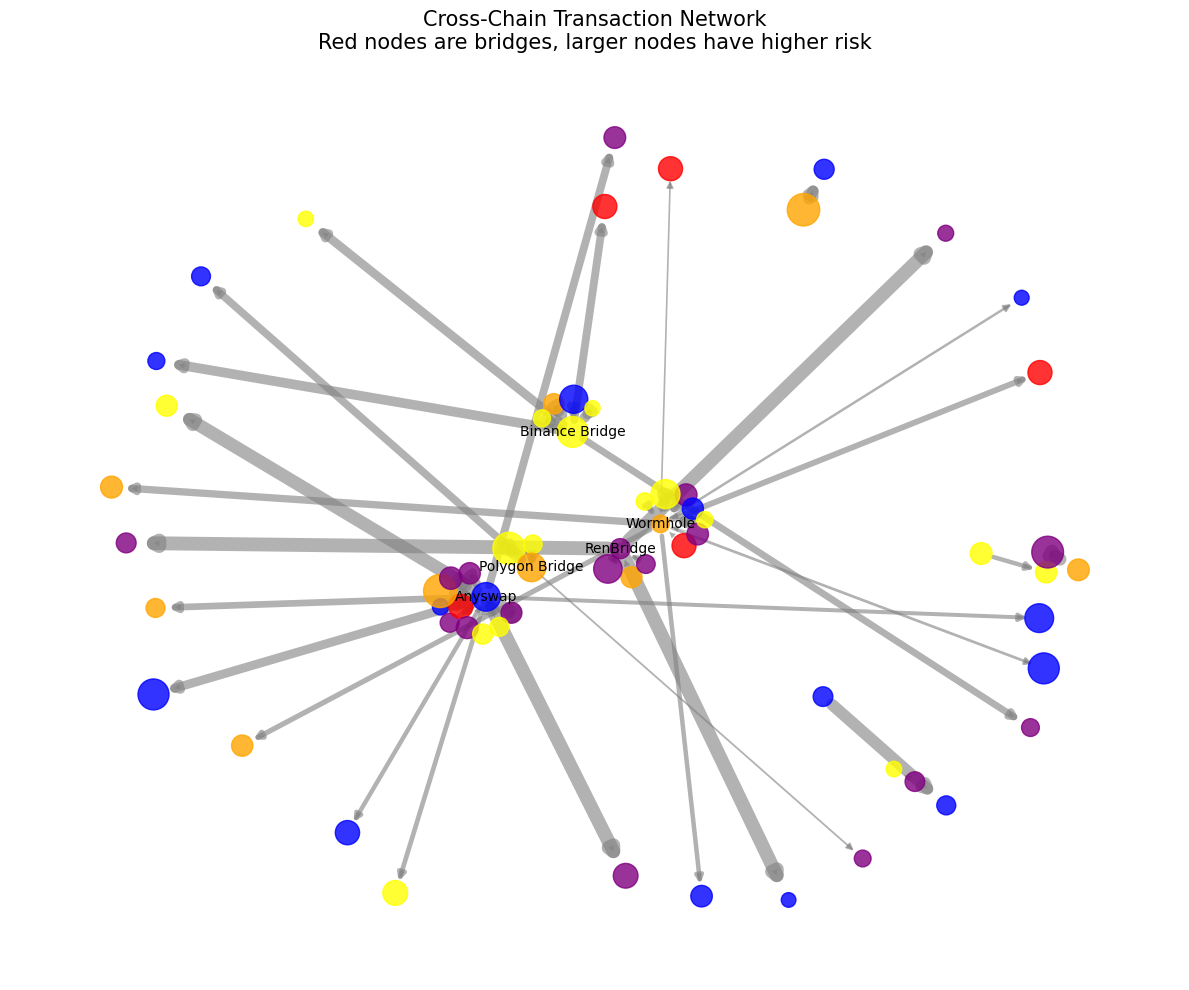

In [12]:
# Generate a network visualization of bridge transactions
def create_network_visualization(n_nodes=50):
    # Create a graph
    G = nx.DiGraph()

    # Get some transactions from our data
    sample_transactions = X_test.iloc[:n_nodes].copy()
    sample_transactions['fraud_probability'] = y_prob[:n_nodes]
    sample_transactions['is_fraud'] = y_pred[:n_nodes]

    # Create nodes (addresses) and edges (transactions)
    chains = ['bitcoin', 'ethereum', 'bsc', 'polygon']
    bridges = ['RenBridge', 'Anyswap', 'Wormhole', 'Polygon Bridge', 'Binance Bridge']

    # Create address nodes
    for i in range(n_nodes):
        # Source address
        source_chain = np.random.choice(chains)
        source_addr = f"addr_{i}_src_{source_chain[:3]}"
        G.add_node(source_addr,
                   type='address',
                   chain=source_chain,
                   risk=np.random.random() if sample_transactions.iloc[i]['is_fraud'] else np.random.random() * 0.3)

        # Destination address - could be on same or different chain
        num_chains = sample_transactions.iloc[i]['unique_chains']
        if num_chains > 1:
            # Different chain
            dest_chain = np.random.choice([c for c in chains if c != source_chain])
            # Add bridge node
            bridge = np.random.choice(bridges)
            G.add_node(bridge, type='bridge')
            # Add edges through bridge
            G.add_edge(source_addr, bridge, value=np.random.random() * 10)

            # Destination address
            dest_addr = f"addr_{i}_dst_{dest_chain[:3]}"
            G.add_node(dest_addr,
                      type='address',
                      chain=dest_chain,
                      risk=np.random.random() if sample_transactions.iloc[i]['is_fraud'] else np.random.random() * 0.3)
            G.add_edge(bridge, dest_addr, value=np.random.random() * 10)
        else:
            # Same chain
            dest_addr = f"addr_{i}_dst_{source_chain[:3]}"
            G.add_node(dest_addr,
                      type='address',
                      chain=source_chain,
                      risk=np.random.random() if sample_transactions.iloc[i]['is_fraud'] else np.random.random() * 0.3)
            G.add_edge(source_addr, dest_addr, value=np.random.random() * 10)

    # Add round-trip patterns for some fraud cases
    for i in range(n_nodes):
        if sample_transactions.iloc[i]['round_trips'] > 0 and sample_transactions.iloc[i]['is_fraud']:
            source_addr = f"addr_{i}_src_{chains[0][:3]}"
            bridge1 = bridges[0]
            dest_addr = f"addr_{i}_dst_{chains[1][:3]}"
            bridge2 = bridges[1]

            # Add round-trip edges if nodes exist
            if source_addr in G and bridge1 in G and dest_addr in G and bridge2 in G:
                if not G.has_edge(dest_addr, bridge2):
                    G.add_edge(dest_addr, bridge2, value=np.random.random() * 5)
                if not G.has_edge(bridge2, source_addr):
                    G.add_edge(bridge2, source_addr, value=np.random.random() * 5)

    return G

# Create network
transaction_network = create_network_visualization(30)
print(f"Created network with {transaction_network.number_of_nodes()} nodes and {transaction_network.number_of_edges()} edges")

# Visualize the network
plt.figure(figsize=(12, 10))

# Set positions
pos = nx.spring_layout(transaction_network, seed=42)

# Draw nodes by type
address_nodes = [node for node, attr in transaction_network.nodes(data=True) if attr.get('type') == 'address']
bridge_nodes = [node for node, attr in transaction_network.nodes(data=True) if attr.get('type') == 'bridge']

# Color map for different chains
chain_colors = {
    'bitcoin': 'orange',
    'ethereum': 'blue',
    'bsc': 'yellow',
    'polygon': 'purple'
}

# Node colors based on chain and type
node_colors = []
for node in transaction_network.nodes():
    attrs = transaction_network.nodes[node]
    if attrs.get('type') == 'bridge':
        node_colors.append('red')
    else:
        chain = attrs.get('chain', 'ethereum')
        risk = attrs.get('risk', 0.1)
        # Adjust color intensity by risk
        color = chain_colors.get(chain, 'gray')
        node_colors.append(color)

# Node sizes based on risk
node_sizes = []
for node in transaction_network.nodes():
    attrs = transaction_network.nodes[node]
    if attrs.get('type') == 'bridge':
        node_sizes.append(300)  # Bridges are larger
    else:
        risk = attrs.get('risk', 0.1)
        node_sizes.append(100 + risk * 500)  # Size by risk

# Draw nodes
nx.draw_networkx_nodes(transaction_network, pos,
                      nodelist=address_nodes + bridge_nodes,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.8)

# Draw edges with width based on value
edge_widths = [transaction_network[u][v].get('value', 1) for u, v in transaction_network.edges()]
nx.draw_networkx_edges(transaction_network, pos, width=edge_widths, alpha=0.6, edge_color='gray', arrows=True)

# Add labels only for bridge nodes - to avoid clutter
labels = {node: node for node in bridge_nodes}
nx.draw_networkx_labels(transaction_network, pos, labels=labels, font_size=10)

plt.title('Cross-Chain Transaction Network\nRed nodes are bridges, larger nodes have higher risk', fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# SQL queries to feed real-time dashboards
print("SQL Queries for Real-time Dashboards:")

risk_overview_query = """
SELECT
    risk_level,
    COUNT(*) as count,
    AVG(risk_score) as avg_score
FROM risk_assessments
GROUP BY risk_level
ORDER BY
    CASE
        WHEN risk_level = 'High' THEN 1
        WHEN risk_level = 'Medium' THEN 2
        ELSE 3
    END;
"""

print("\n1. Risk Overview Query:")
print(risk_overview_query)

bridge_activity_query = """
SELECT
    json_extract(transaction_data, '$.bridge_count') as bridge_count,
    COUNT(*) as transaction_count,
    AVG(risk_score) as avg_risk,
    SUM(CASE WHEN is_suspicious = 1 THEN 1 ELSE 0 END) as suspicious_count
FROM risk_assessments
GROUP BY bridge_count
ORDER BY bridge_count;
"""

print("\n2. Bridge Activity Query:")
print(bridge_activity_query)

chain_hopping_query = """
SELECT
    json_extract(transaction_data, '$.unique_chains') as chain_count,
    json_extract(transaction_data, '$.chain_hop_frequency') as hop_frequency,
    COUNT(*) as transaction_count,
    AVG(risk_score) as avg_risk
FROM risk_assessments
GROUP BY chain_count, hop_frequency
ORDER BY avg_risk DESC;
"""

print("\n3. Chain Hopping Analysis Query:")
print(chain_hopping_query)

time_pattern_query = """
SELECT
    strftime('%H', timestamp) as hour_of_day,
    COUNT(*) as transaction_count,
    AVG(risk_score) as avg_risk,
    SUM(CASE WHEN is_suspicious = 1 THEN 1 ELSE 0 END) as suspicious_count
FROM risk_assessments
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""

print("\n4. Time Pattern Analysis Query:")
print(time_pattern_query)

recent_high_risk_query = """
SELECT
    id,
    timestamp,
    risk_score,
    risk_level,
    json_extract(transaction_data, '$.bridge_count') as bridge_count,
    json_extract(transaction_data, '$.unique_chains') as chain_count,
    json_extract(transaction_data, '$.round_trips') as round_trips
FROM risk_assessments
WHERE risk_level = 'High'
ORDER BY timestamp DESC
LIMIT 10;
"""

print("\n5. Recent High-Risk Transactions Query:")
print(recent_high_risk_query)

SQL Queries for Real-time Dashboards:

1. Risk Overview Query:

SELECT 
    risk_level,
    COUNT(*) as count,
    AVG(risk_score) as avg_score
FROM risk_assessments
GROUP BY risk_level
ORDER BY 
    CASE 
        WHEN risk_level = 'High' THEN 1
        WHEN risk_level = 'Medium' THEN 2
        ELSE 3
    END;


2. Bridge Activity Query:

SELECT 
    json_extract(transaction_data, '$.bridge_count') as bridge_count,
    COUNT(*) as transaction_count,
    AVG(risk_score) as avg_risk,
    SUM(CASE WHEN is_suspicious = 1 THEN 1 ELSE 0 END) as suspicious_count
FROM risk_assessments
GROUP BY bridge_count
ORDER BY bridge_count;


3. Chain Hopping Analysis Query:

SELECT 
    json_extract(transaction_data, '$.unique_chains') as chain_count,
    json_extract(transaction_data, '$.chain_hop_frequency') as hop_frequency,
    COUNT(*) as transaction_count,
    AVG(risk_score) as avg_risk
FROM risk_assessments
GROUP BY chain_count, hop_frequency
ORDER BY avg_risk DESC;


4. Time Pattern Analysis Que

In [15]:
!pip install streamlit pandas numpy matplotlib seaborn plotly networkx scikit-learn joblib pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [16]:
# Save this as setup.py and run once
import sqlite3
import joblib
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Create a simple database
conn = sqlite3.connect('crypto_fraud.db')
cursor = conn.cursor()

# Create a simple table for risk assessments
cursor.execute('''
CREATE TABLE IF NOT EXISTS risk_assessments (
    id INTEGER PRIMARY KEY,
    timestamp TEXT,
    transaction_data TEXT,
    is_suspicious INTEGER,
    risk_score REAL,
    risk_level TEXT
)
''')

conn.commit()
conn.close()

# Create simple ML model and scaler
model = GradientBoostingClassifier()
X_train = np.random.random((100, 11))
y_train = (np.random.random(100) > 0.7).astype(int)
model.fit(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_train)

# Save the model files
joblib.dump(model, 'cross_chain_fraud_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("Setup complete! Database and model files created.")

Setup complete! Database and model files created.


In [17]:
%%writefile app.py
# Paste the entire Streamlit code here

Writing app.py


In [18]:
%%writefile setup.py
# Paste the setup code here

Writing setup.py


In [19]:
!pip install streamlit pandas numpy matplotlib seaborn plotly networkx scikit-learn joblib

In [20]:
!python setup.py

In [22]:
# Install required packages
!pip install streamlit pandas numpy matplotlib seaborn plotly networkx scikit-learn joblib

# Run setup.py (make sure you've created this file already)
!python setup.py

# For Colab, use the built-in method to expose the Streamlit app
from google.colab import output
output.serve_kernel_port_as_window(8501)

# Start Streamlit in the background
!streamlit run app.py &>/dev/null &

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [23]:
# Start Streamlit
!streamlit run app.py &>/dev/null &

# Use localtunnel to expose the port
!npm install -g localtunnel
!lt --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
added 22 packages in 5s
⠏
⠏3 packages are looking for funding
⠏  run `npm fund` for details
⠏your url is: https://empty-gifts-stop.loca.lt
^C
